In [324]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [325]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    # print("Done")

def dist(p1, p2):
    return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def show_points(img, p1, p2):
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img = cv2.circle(img, p1, 1, (0, 0, 255), -1)
    img = cv2.circle(img, p2, 1, (255, 0, 0), -1)
    show_image(img)

def flipped(image):
    

    return False

In [326]:
def solution(image_path):
    ############################
    ############################
    
    original_image = cv2.imread(image_path)
    gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY) # grayscale mei convert karo
    gray = cv2.bitwise_not(gray) # grayscale image invert karo taki thresholding sahi se ho
    thresh_val, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # perform OTSU thresholding

    ## Testing code to display the image
    # print("Threshold value: ", thresh_val)
    
    # show_image(thresh)

    fourier = cv2.dft(np.float32(thresh), flags=cv2.DFT_COMPLEX_OUTPUT)

    # Shift the zero-frequency component to the center of the spectrum
    fourier_shift = np.fft.fftshift(fourier)
    
    # calculate the magnitude of the Fourier Transform
    magnitude = 20*np.log(cv2.magnitude(fourier_shift[:,:,0],fourier_shift[:,:,1]))
    
    # Scale the magnitude for display
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

    image = cv2.threshold(magnitude, 220, 255, cv2.THRESH_BINARY)[1]

    # show_image(image)

    xmax = 0
    ymax = 0
    xmin = image.shape[1]
    ymin = image.shape[0]



    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] == 255:
                if i > ymax:
                    bottom_y = j,i
                    ymax = i
                if i < ymin:
                    top_y = j,i
                    ymin = i
                if j > xmax:
                    right_x = j,i
                    xmax = j
                if j < xmin:
                    left_x = j, i
                    xmin = j

    # print(top_y, bottom_y, left_x, right_x)
    # show_points(image, top_y, bottom_y)
    # show_points(image, left_x, right_x)
    # print(dist(left_x, right_x))

    left, right = ((left_x, right_x) if dist(left_x, right_x) > dist(top_y, bottom_y) else (top_y, bottom_y))

    if(left[0] > right[0]):
        left, right = right, left
    
    # show_points(image, left, right)
    
    # print(left, right)
    
    slope = np.arctan((right[1] - left[1])/(right[0] - left[0])) if right[0] != left[0] else np.pi/2
    angle = slope * 180 / np.pi
    print(angle)
    if angle < 0:
        angle = 90 + angle - (5 if (-70<angle<-20) else 0) #adding 5 for correction by observation
    else:
        angle = -(90-angle) + (5 if (20<angle<70) else 0)

    image = original_image
    h,w = image.shape[:2]
    cX, cY = (w//2, h//2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    if flipped(image): #if image is flipped, rotate by 180
        M = cv2.getRotationMatrix2D((cX, cY), 180, 1.0)
        image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)

    # show_image(image)
    # print(angle)
    
    ############################
    return image
    


-53.13010235415598


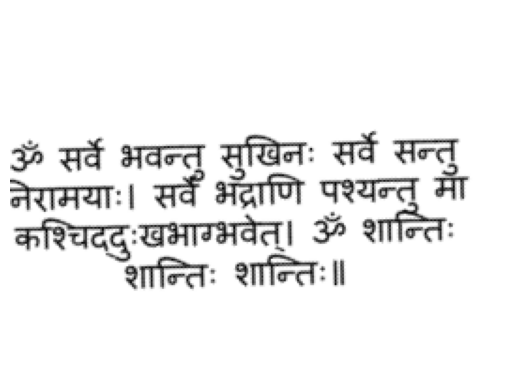

In [327]:
show_image(solution("test/3_a.png"))  

90.0


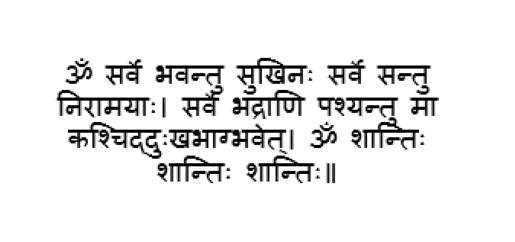

In [328]:
show_image(solution("test/3_b.png"))  

45.0


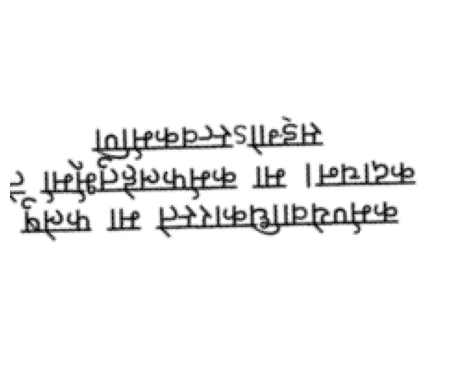

In [329]:
show_image(solution("test/3_c.png"))  

90.0


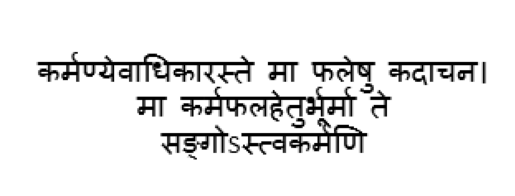

In [330]:
show_image(solution("test/3_d.png"))    